In [106]:
# importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
from scipy.optimize import curve_fit

In [92]:
# gathering all the data
df_age_causes = pd.DataFrame()
for i in [
    'all-causes',\
    'communicable-maternal-perinatal-nutritional-conditions',\
    'noncommunicable-diseases',\
    'Injuries',\
    'ill-defined-diseases',\
]:
    df = pd.read_csv(f"data/{i}.csv")
    df.drop([
        'Age Group',\
        'Percentage of cause-specific deaths out of total deaths',\
        'Region Code',\
        'Region Name',\
        'Country Name',\
            ], axis=1, inplace=True)
    df = df.rename(columns={'Death rate per 100 000 population':'Death rate'})
    # cleaning the data frames
    df_reduced = pd.DataFrame()
    df_reduced = df[(df['Year'] > 1959) & (df['Year'] < 2020)]
    df_reduced = df_reduced[df_reduced['Age group code'] != 'Age_unknown']
    # final data frame
    df_reduced =  df_reduced[(df_reduced['Country Code'] == 'JPN') | (df_reduced['Country Code'] == 'CHE')]
    df_reduced['causes'] = i
    df_age_causes = pd.concat([df_age_causes, df_reduced], ignore_index=True)

In [93]:
df = pd.read_csv("data/all-causes.csv")
df.drop([
    'Age Group',\
    'Percentage of cause-specific deaths out of total deaths',\
    'Region Code',\
    'Region Name',\
    'Country Name',\
        ], axis=1, inplace=True)
df = df.rename(columns={'Death rate per 100 000 population':'Death rate'})
# cleaning the data frame
df_reduced = pd.DataFrame()
df_reduced = df[(df['Year'] > 1959) & (df['Year'] < 2020)]
df_reduced = df_reduced[df_reduced['Age group code'] != 'Age_unknown']
# final data frame
df_reduced =  df_reduced[(df_reduced['Country Code'] == 'JPN') | (df_reduced['Country Code'] == 'CHE')]
df_reduced['causes'] = "all_causes"
df_age_causes = pd.concat([df_age_causes, df_reduced], ignore_index=True)

In [94]:
# classify years by 10
from utils import year_classification
df_age_causes['Year'] = df_age_causes['Year'].apply(year_classification)

# dividing the data into ten year period data frames
df_1960_1970 = df_age_causes[df_age_causes['Year'] == "1960-1970"]
df_1970_1980 = df_age_causes[df_age_causes['Year'] == "1970-1980"]
df_1980_1990 = df_age_causes[df_age_causes['Year'] == "1980-1990"]
df_1990_2000 = df_age_causes[df_age_causes['Year'] == "1990-2000"]
df_2000_2010 = df_age_causes[df_age_causes['Year'] == "2000-2010"]
df_2010_2020 = df_age_causes[df_age_causes['Year'] == "2010-2020"]

# transforming the data frames and putting them in a dictionary to make data analysis
unique_ages = sorted(df_age_causes['Age group code'].unique())
unique_genders = sorted(df_age_causes['Sex'].unique())
unique_causes = sorted(df_age_causes['causes'].unique())
unique_countries = sorted(df_age_causes['Country Code'].unique())
dfs = {}
for year in ["1960-1970","1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"] :
    df_extract = df_age_causes[df_age_causes['Year'] == year]
    df_name = f'df_{year}'
    dfs[df_name] = pd.DataFrame(columns = ['age','gender','cause','JPN_death_rate','CHE_death_rate'])
    for age in unique_ages:
        for gender in unique_genders:
            for cause in unique_causes:
                death_jpn = df_extract[
                    (df_extract['Age group code'] == age) &\
                    (df_extract['Sex'] == gender) &\
                    (df_extract['causes'] == cause) &\
                    (df_extract['Country Code'] == 'JPN')
                ]['Death rate'].sum()/10
                death_che = df_extract[
                    (df_extract['Age group code'] == age) &\
                    (df_extract['Sex'] == gender) &\
                    (df_extract['causes'] == cause) &\
                    (df_extract['Country Code'] == 'CHE')
                ]['Death rate'].sum()/10
                new_row = {
                    'age':age,
                    'gender':gender,
                    'cause':cause,
                    'JPN_death_rate':death_jpn,
                    'CHE_death_rate':death_che
                }
                dfs[df_name] = dfs[df_name].append(new_row, ignore_index=True)
                dfs[df_name]['age'] = dfs[df_name]['age'].apply(lambda x: x.replace("_", "").replace("Age", ""))




In [95]:

# Computing if the differences between women and men in different age groups are significant

significance_age = pd.DataFrame(columns=['year','cause','JPN_significant','CHE_significant'])
unique_causes = sorted(df_age_causes['causes'].unique())
unique_causes.remove('all_causes')
for key, data_frame in dfs.items():
    for cause in unique_causes:
        target = data_frame[data_frame['cause'] == 'all_causes']
        target.drop(target.tail(3).index,inplace = True)

        country = 'JPN_death_rate'
        male_data = target[target['gender'] == 'Male'][country]
        female_data = target[target['gender'] == 'Female'][country]

        # Perform the Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

        # Check if the difference is significant
        alpha = 0.05  # Set your desired significance level
        if p_value < alpha:
            j = "Yes"
        else:
            j = "No"
        country = 'CHE_death_rate'
        male_data = target[target['gender'] == 'Male'][country]
        female_data = target[target['gender'] == 'Female'][country]

        # Perform the Mann-Whitney U test
        statistic, p_value = stats.mannwhitneyu(male_data, female_data, alternative='two-sided')

        # Check if the difference is significant
        alpha = 0.05  # Set your desired significance level
        if p_value < alpha:
            c = "Yes"
        else:
            c = "No"

        new_row = {
            'year': key,
            'cause': cause,
            'JPN_significant': j,
            'CHE_significant': c
        }

        significance_age = significance_age.append(new_row, ignore_index=True)

significance_age

,year,cause,JPN_significant,CHE_significant
0,df_1960-1970,Injuries,No,No
1,df_1960-1970,all-causes,No,No
2,df_1960-1970,communicable-maternal-perinatal-nutritional-co...,No,No
3,df_1960-1970,ill-defined-diseases,No,No
4,df_1960-1970,noncommunicable-diseases,No,No
5,df_1970-1980,Injuries,No,No
6,df_1970-1980,all-causes,No,No
7,df_1970-1980,communicable-maternal-perinatal-nutritional-co...,No,No
8,df_1970-1980,ill-defined-diseases,No,No
9,df_1970-1980,noncommunicable-diseases,No,No


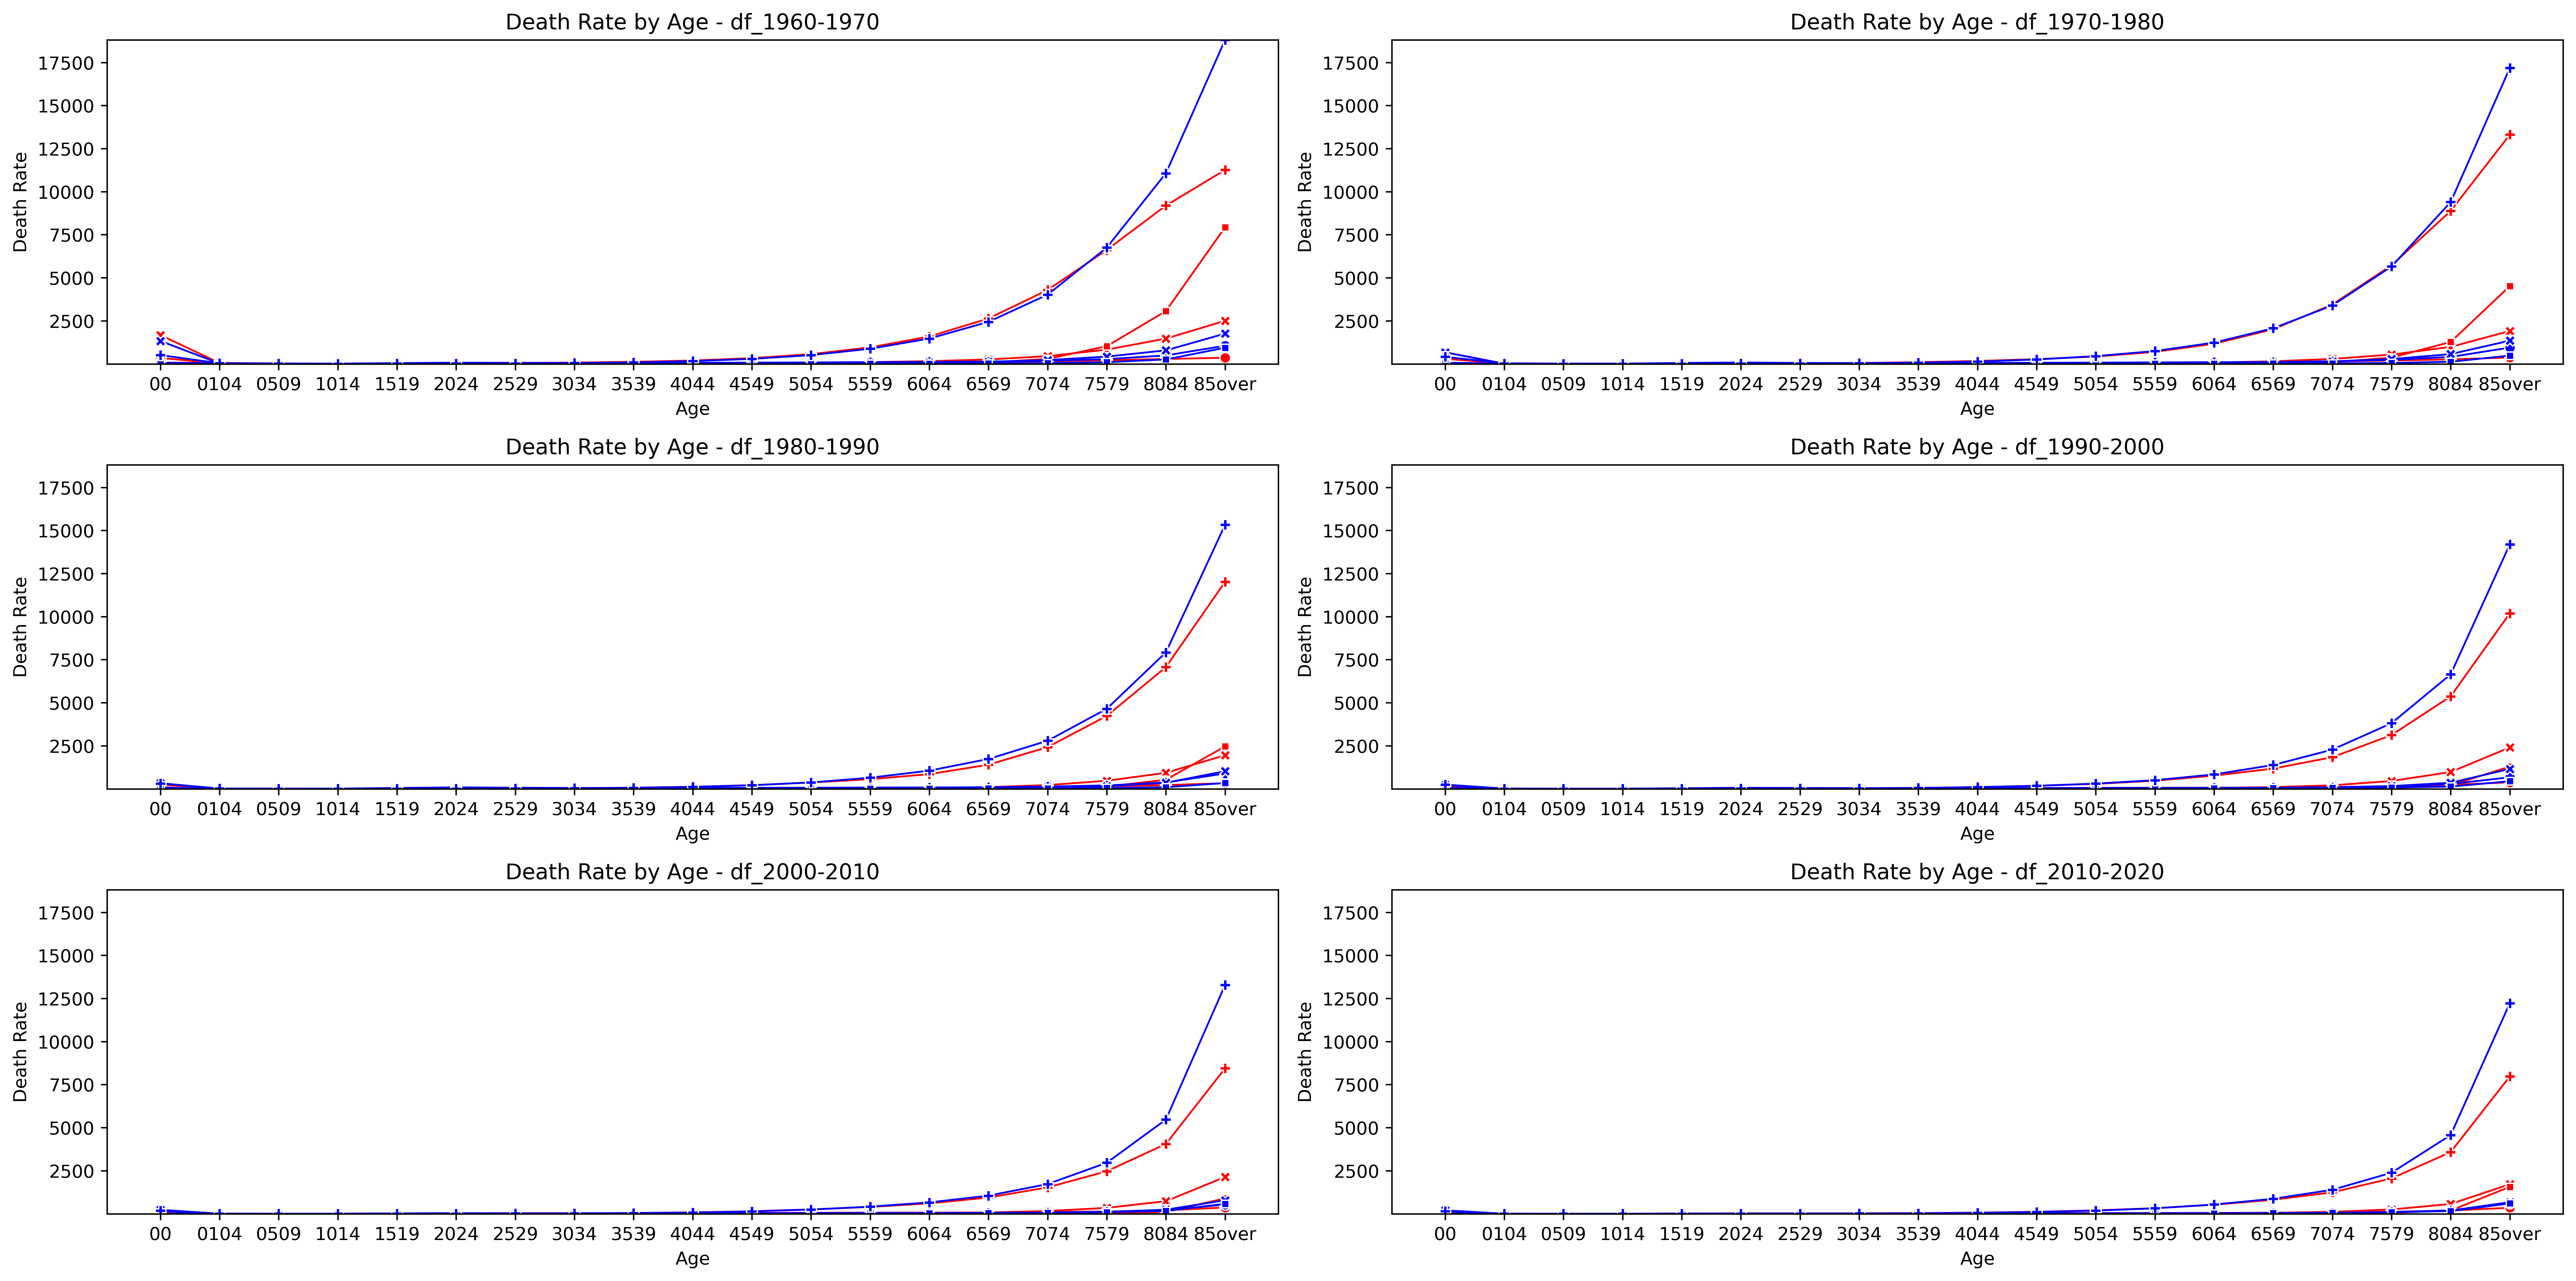

In [96]:

#pair plots for age-cause analysis in different periods.

fig, axes = plt.subplots(3, 2, figsize=(20, 10), dpi=480)
axes = axes.flatten()
global_y_min = float('inf')
global_y_max = float('-inf')

for i, (key, df) in enumerate(dfs.items()):
    filtered_df = df[(df['cause'] != 'all-causes') & (df['cause'] != 'all_causes') & (df['gender'] == 'All') & (df['age'] != 'all')]

    local_y_min = filtered_df[['JPN_death_rate', 'CHE_death_rate']].min().min()
    local_y_max = filtered_df[['JPN_death_rate', 'CHE_death_rate']].max().max()

    global_y_min = min(global_y_min, local_y_min)
    global_y_max = max(global_y_max, local_y_max)

    sns.set_palette(["red", "blue"])  
    sns.lineplot(data=filtered_df, x='age', y='JPN_death_rate', style='cause', markers=True, dashes=False, markersize=6, linewidth=1, ax=axes[i])
    sns.lineplot(data=filtered_df, x='age', y='CHE_death_rate', style='cause', markers=True, dashes=False, markersize=6, linewidth=1, ax=axes[i])

    axes[i].get_legend().remove()

    axes[i].set_ylim(global_y_min, global_y_max)

    axes[i].set_xlabel("Age", fontsize=10)  
    axes[i].set_ylabel("Death Rate")
    axes[i].set_title(f"Death Rate by Age - {key}")

plt.tight_layout()

plt.show()


In [97]:
# Barchart for each age, causes-death
unique_years = df_age_causes['Year'].unique()
dfs = {}
df_extract = df_age_causes[df_age_causes['Age group code'] == age]



for age in unique_ages :
     df_extract = df_age_causes[df_age_causes['Age group code'] == age]
     df_name = f'df_{age}'
     dfs[df_name] = pd.DataFrame(columns = ['gender','cause','JPN_death_rate','CHE_death_rate'])
     for gender in unique_genders:
          for cause in unique_causes:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'cause':cause,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               dfs[df_name] = dfs[df_name].append(new_row, ignore_index=True)


fig, axes = plt.subplots(4, 5, figsize=(20, 12), dpi=480)
fig.tight_layout(h_pad=4)

axes = axes.flatten()

for i, (key, df) in enumerate(dfs.items()):
    df = df[(df['cause'] != 'all-causes') & (df['cause'] != 'all_causes') & (df['gender'] == 'All')]

    df_long = df.melt(id_vars=['cause'], value_vars=['JPN_death_rate', 'CHE_death_rate'], var_name='Country', value_name='Death_Rate')

    sns.set_palette(["red", "blue"])  
    sns.barplot(data=df_long, x='cause', y='Death_Rate', hue='Country', ax=axes[i])

    axes[i].set_xticklabels([1,2,3,4]) 
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_title(f"Death Rate by Cause - {key}")

    axes[i].get_legend().remove()

axes[-1].set_xlabel("Cause")

plt.show()

In [98]:
# line chart for age - all-cause
# the average of death rate(all-causes) in all years

df_extract = df_age_causes[df_age_causes['causes'] == 'all-causes']
df_plot = pd.DataFrame(columns = ['gender','age','JPN_death_rate','CHE_death_rate'])
for age in unique_ages :
     for gender in unique_genders:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['Age group code'] == age) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['Age group code'] == age) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'age':age,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               df_plot = df_plot.append(new_row, ignore_index=True)
               df_plot['age'] = df_plot['age'].apply(lambda x: x.replace("_", "").replace("Age", ""))


In [99]:
df_filtered = df_plot[df_plot['gender'] == "All"]
df_filtered
df_filtered = df_filtered.reset_index(drop=True)
df_filtered = df_filtered.drop(df_filtered.index[-1])

# converting age groups to integers
for i in range(0,len(df_filtered['age']),) :
     if i > 0 :
          df_filtered.loc[i,'age_linear'] =  4+(i-1)*5
     else:
          df_filtered.loc[i,'age_linear'] = 0

# We assume if we don't take the first two age groups into account, the relationship is between age group and death rate is exponential.
age_groups = df_filtered['age_linear'][2:]
death_rates_JPN = df_filtered['JPN_death_rate'][2:]
death_rates_CHE = df_filtered['CHE_death_rate'][2:]

In [111]:
# getting the log linear function
from utils import log_linear_function

# Apply log transformation to the death rates
log_death_rates_JPN = np.log(death_rates_JPN)
log_death_rates_CHE = np.log(death_rates_CHE)

# Fitting the log-linear line
params_JPN, covariance_JPN = curve_fit(log_linear_function, age_groups, log_death_rates_JPN)
ln_alpha_JPN, beta_JPN = params_JPN

params_CHE, covariance_CHE = curve_fit(log_linear_function, age_groups, log_death_rates_CHE)
ln_alpha_CHE, beta_CHE = params_CHE

# Create a range of x values for the curve
x_fit = np.linspace(min(age_groups), max(age_groups), 100)
y_fit_JPN = np.exp(log_linear_function(x_fit, ln_alpha_JPN, beta_JPN))
y_fit_CHE = np.exp(log_linear_function(x_fit, ln_alpha_CHE, beta_CHE))

# Plotting
plt.figure(figsize=(10, 6), dpi=480)

plt.scatter(age_groups, death_rates_JPN, label="JPN Data", color='red')
plt.plot(x_fit, y_fit_JPN, 'r', label=f'Log-Linear Fit (JPN): y = {ln_alpha_JPN:.2f} + {beta_JPN:.2f}x', linestyle='--')

plt.scatter(age_groups, death_rates_CHE, label="CHE Data", color='blue')
plt.plot(x_fit, y_fit_CHE, 'b', label=f'Log-Linear Fit (CHE): y = {ln_alpha_CHE:.2f} {beta_CHE:.2f}x', linestyle='--')

plt.xlabel('Age (Numerical)')
plt.ylabel('Death Rate')
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.legend()
plt.title('Log-Linear Fit of Death Rate Data for JPN and CHE')
plt.grid(True)
plt.show()

# Calculate the correlation coefficient for JPN
correlation_JPN, _ = stats.pearsonr(age_groups, log_death_rates_JPN)
print(f'Correlation (JPN) between Age and Log-Death Rate: {correlation_JPN:.3f}')

# Calculate the correlation coefficient for CHE
correlation_CHE, _ = stats.pearsonr(age_groups, log_death_rates_CHE)
print(f'Correlation (CHE) between Age and Log-Death Rate: {correlation_CHE:.3f}')


ImportError: cannot import name 'log_linear_function' from 'utils' (c:\Users\Asus\Desktop\new -data-analytics\Mortality-rate-second\utils.py)

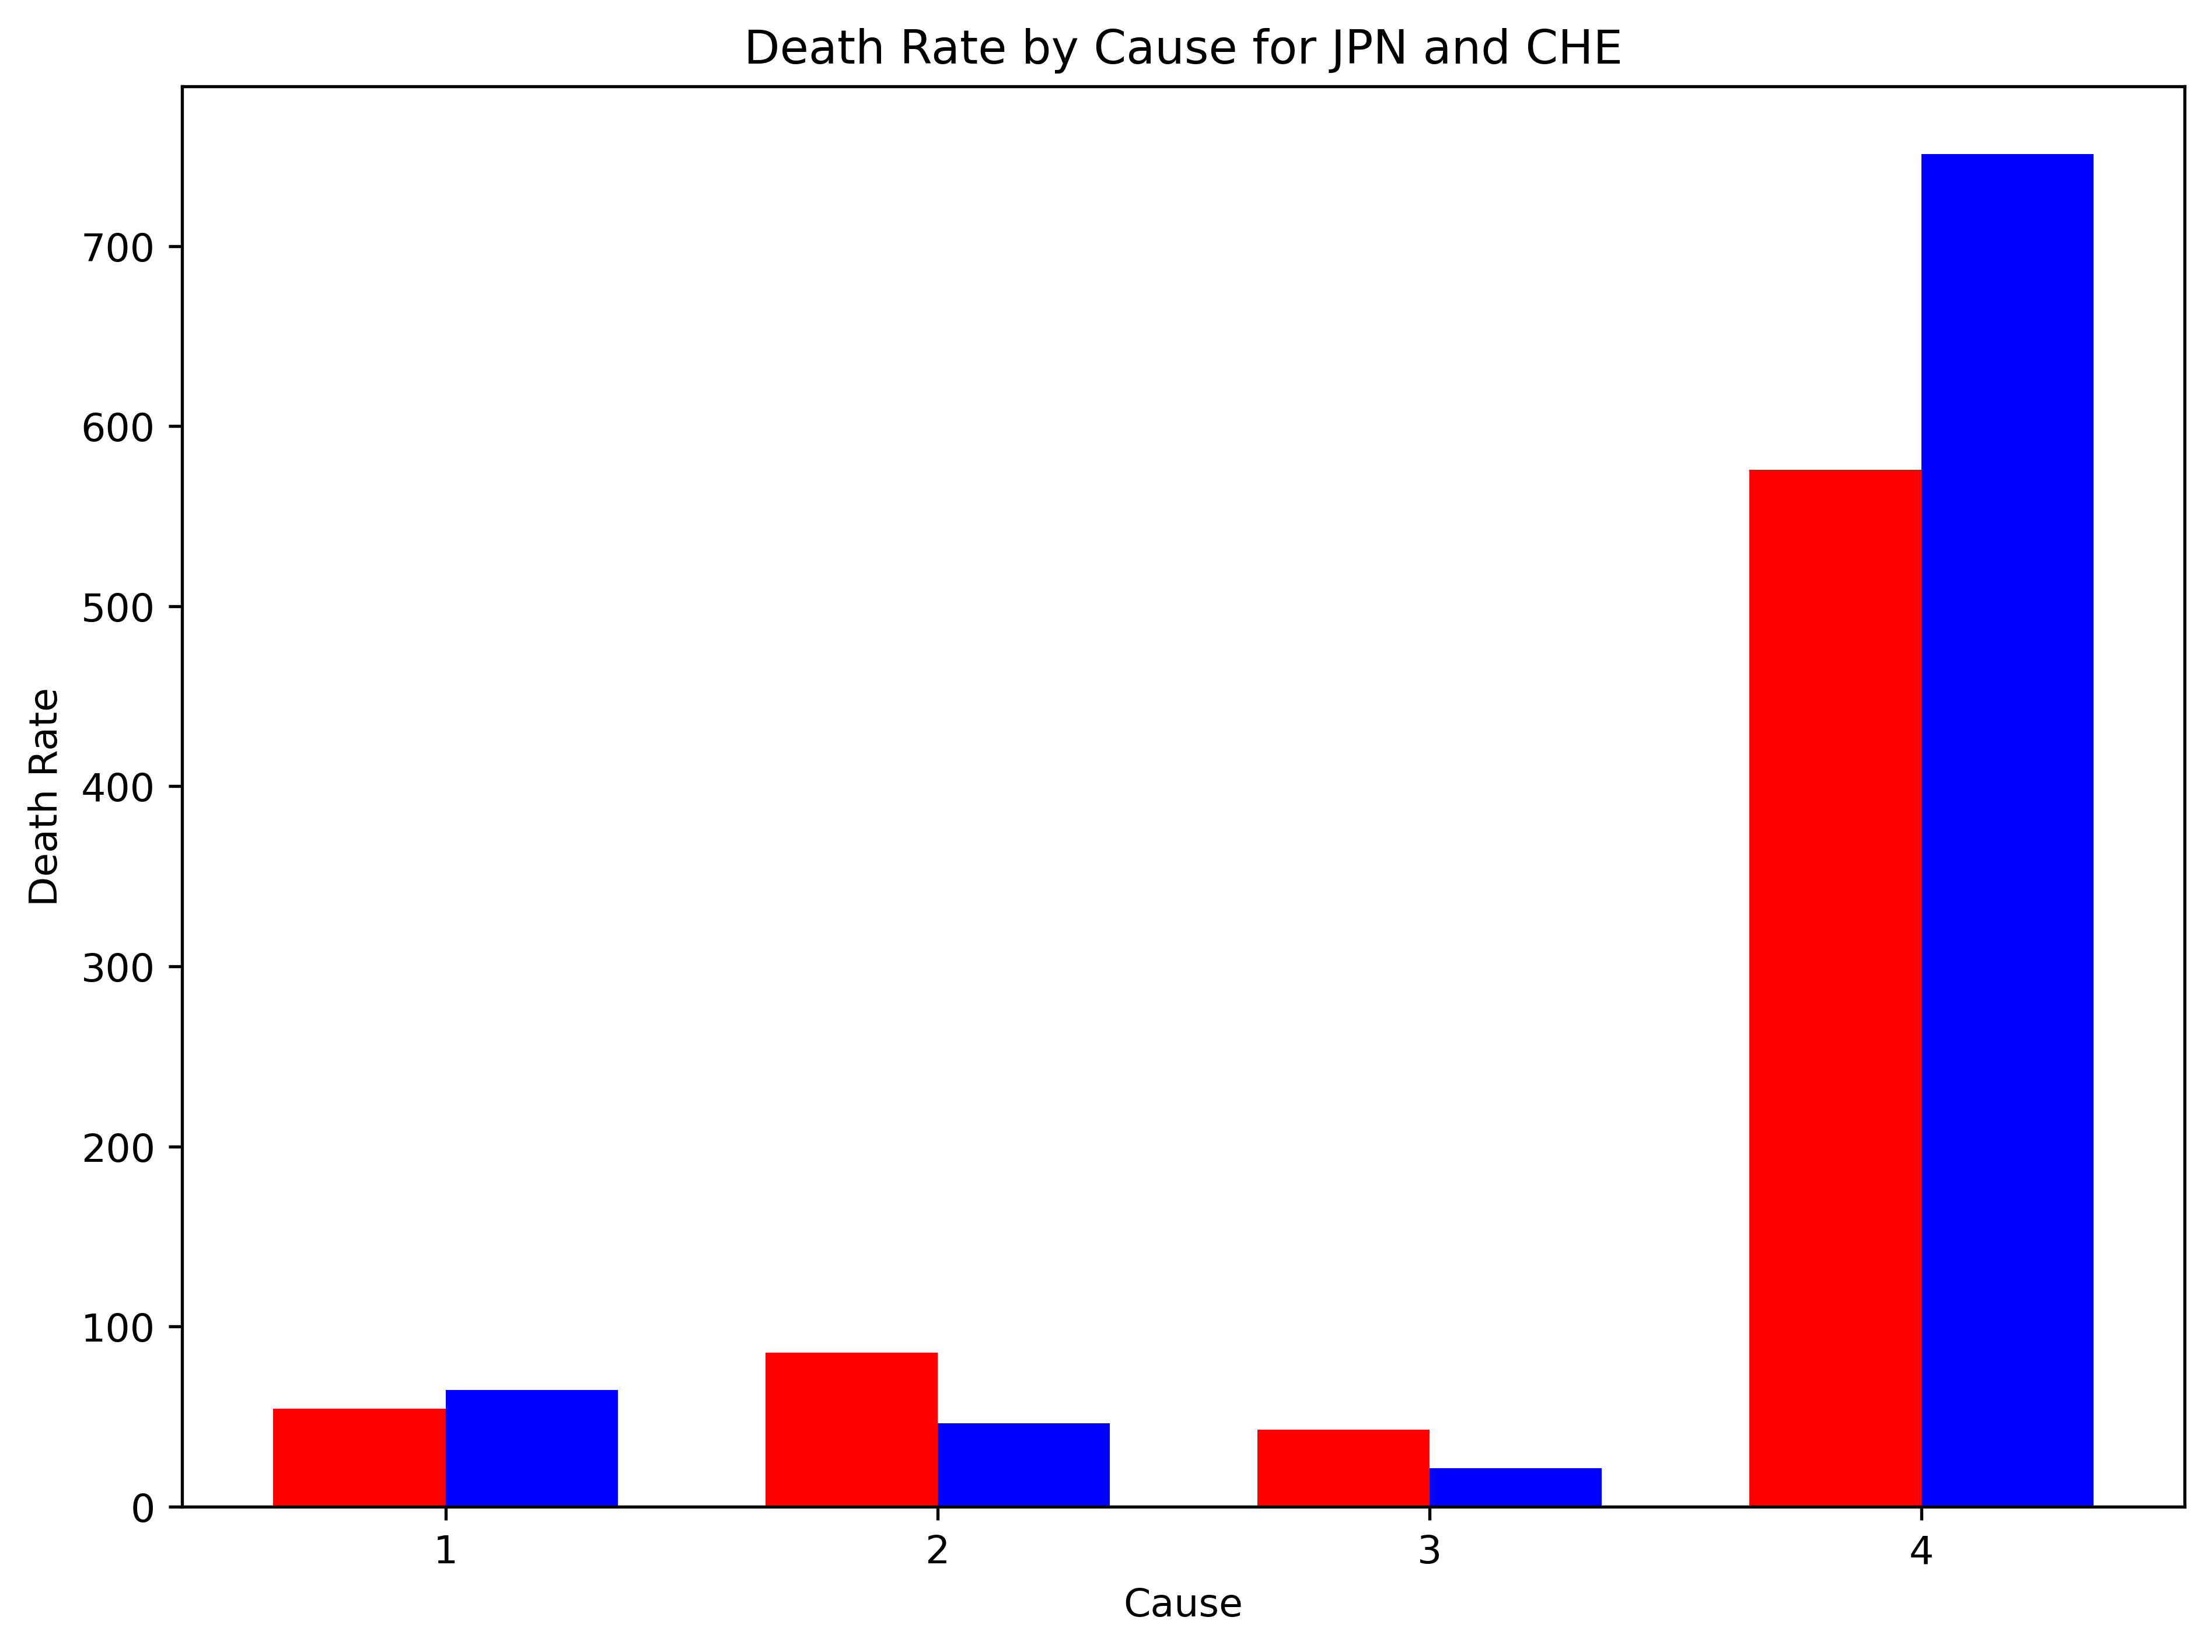

In [105]:
# bar chart for each cause death rate for all years and all ages
# the average of death rate(all-ages) in all years

df_extract = df_age_causes[df_age_causes['Age group code'] == 'Age_all']
df_plot = pd.DataFrame(columns = ['gender','cause','JPN_death_rate','CHE_death_rate'])
for cause in unique_causes :
     for gender in unique_genders:
               death_jpn = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'JPN')
               ]['Death rate'].sum()/60
               death_che = df_extract[
               (df_extract['Sex'] == gender) &\
               (df_extract['causes'] == cause) &\
               (df_extract['Country Code'] == 'CHE')
               ]['Death rate'].sum()/60
               new_row = {
               'gender':gender,
               'cause':cause,
               'JPN_death_rate':death_jpn,
               'CHE_death_rate':death_che
               }
               df_plot = df_plot.append(new_row, ignore_index=True)
               
df = df_plot[(df_plot['gender'] == 'All') & (df_plot['cause'] != 'all-causes') & (df_plot['cause'] != 'all_causes')]
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6), dpi=480)

x = range(len(df['cause']))

# Create bars for JPN_death_rate and CHE_death_rate
ax.bar(x, df['JPN_death_rate'], width, label='JPN', color='red')
ax.bar([i + width for i in x], df['CHE_death_rate'], width, label='CHE', color='blue')

ax.set_xticks([i + width/2 for i in x])
ax.set_xticklabels([1,2,3,4]) 

ax.set_xlabel('Cause')
ax.set_ylabel('Death Rate')
ax.set_title('Death Rate by Cause for JPN and CHE')


plt.tight_layout()
plt.show()

# report all-cause just in number'

## End of Notebook